In [3]:
# %load_ext fireducks.pandas
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pymarketng.application.Mechanism import *
from pymarketng.application.Utils import *
from pymarketng.application.BidsManager import BidsManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph
from pymarketng.application.Market import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import fireducks.pandas as pd
import numpy as np
from typing import Callable, List, Type, Generator
import random
from collections import Counter
# import cProfile


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset

In [4]:
# raw_df1 = pd.read_csv('datasets/7/final_df_type1.csv')
# raw_df2 = pd.read_csv('datasets/7/final_df_type2.csv')
# raw_df3 = pd.read_csv('datasets/7/final_df_type3.csv')
# raw_df1 = pd.read_csv('datasets/20/final_df_type1.csv')
# raw_df2 = pd.read_csv('datasets/20/final_df_type2.csv')
# raw_df3 = pd.read_csv('datasets/20/final_df_type3.csv')
raw_df1 = pd.read_csv('datasets/all/final_df.csv')
# raw_df.fillna(0, inplace=True)
# raw_df1.dropna(inplace=True)
# raw_df2.dropna(inplace=True)
# raw_df3.dropna(inplace=True)

# pd.merge(raw_df3 ,pd.merge(raw_df2, raw_df1,  how='inner', on=['time']), how='inner', on=['time'])
# raw_df3

# TODO: drop is_seller nans


/tmp/ipykernel_86775/157697723.py:7: DtypeWarning: Columns (8,21,34,47,60,73,86,99,112,125) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df1 = pd.read_csv('datasets/all/final_df.csv')


In [5]:
# r = [raw_df1, raw_df2, raw_df3]
r = [raw_df1]
# Converting the shape of df to a simpler form (creating all_bids df)
new_list=[]
for raw_df in r:
    number_of_users = len([col for col in raw_df.columns if col.startswith('type')])
    first_user_num = int(''.join(filter(str.isdigit, raw_df.columns[1])))
    for i in range(first_user_num, first_user_num + number_of_users):
        bid = {
            "time":raw_df['time'],
            "is_peak":raw_df[f'is_peak_user{i}'],
            "load":raw_df[f'load_user{i}'],
            "generate":raw_df[f'generate_user{i}'] if f'generate_user{i}' in raw_df.columns else None,
            "SOC":raw_df[f'SOC_user{i}'] if f'SOC_user{i}' in raw_df.columns else None,
            'unit':raw_df[f'unit_user{i}'],
            "price":raw_df[f'price_user{i}'],
            "is_seller":raw_df[f'is_seller_user{i}'].astype(bool) if f'is_seller_user{i}' in raw_df.columns else False,
            "user": i,
            "type": raw_df[f'type_user{i}']
        }
        new_list.append(pd.DataFrame(bid))
df = pd.concat(new_list)

# drop bids with unit == 0 or price == 0
df = df[df['unit'] != 0]
df = df[df['price'] != 0]

# parsing the time
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour

# calculate price per unit
df['price'] = df['price'] / df['unit']

# compatability
df['is_buying'] = ~df['is_seller']

#
# df.loc[df['is_seller'] == True, 'unit'] *= 1.5
# df.loc[df['is_seller'] == True, 'unit'] += 200

# df.loc[df['is_seller'] == False, 'price'] *= 1.0
# df.loc[df['is_seller'] == False, 'unit'] += 200

df.reset_index(drop=True,inplace=True)
df

/tmp/ipykernel_86775/3092724005.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(new_list)


,time,is_peak,load,generate,SOC,unit,price,is_seller,user,type,hour,is_buying
0,2013-04-05 00:00:00,False,401.0,0.0,0.0,401.0,15.334469,False,0,3,0,True
1,2013-04-05 01:00:00,False,374.0,0.0,0.0,374.0,15.420419,False,0,3,1,True
2,2013-04-05 02:00:00,False,511.0,0.0,0.0,511.0,15.434803,False,0,3,2,True
3,2013-04-05 03:00:00,False,370.0,0.0,0.0,370.0,15.396081,False,0,3,3,True
4,2013-04-05 04:00:00,False,281.0,0.0,0.0,281.0,15.381224,False,0,3,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...
774603,2016-03-19 19:00:00,True,958.0,NaN,NaN,958.0,15.501363,False,29,1,19,True
774604,2016-03-19 20:00:00,True,1241.0,NaN,NaN,1241.0,15.340688,False,29,1,20,True
774605,2016-03-19 21:00:00,True,1448.0,NaN,NaN,1448.0,15.514686,False,29,1,21,True
774606,2016-03-19 22:00:00,False,1439.0,NaN,NaN,1439.0,14.603599,False,29,1,22,True


In [6]:
# split sellers and buyers to different dataframes
buyers_df = df[df['is_seller'] == False]
sellers_df = df[df['is_seller'] == True]

In [7]:
d_b = buyers_df.groupby('time').agg({'unit': 'sum'}).reset_index()
d_s = sellers_df.groupby('time').agg({'unit': 'sum'}).reset_index()
merged_df = pd.merge(d_b,d_s, on='time', how='inner',suffixes=('_buyers', '_sellers') )
merged_df.to_csv('units_df.csv', index=False, header=True, sep=',', encoding='utf-8')
merged_df['unit_buyers'] - merged_df['unit_sellers']

0         7568.097024
1         -272.348922
2       -13956.663227
3       -19096.927452
4       -19418.212837
             ...     
25865    17065.643676
25866    16129.138260
25867    18538.293355
25868    25999.925045
25869    15480.605116
Length: 25870, dtype: float64

In [8]:
time_list = df['time'].unique()
num_rounds=len(time_list)
num_rounds

25920

### Max and Min Price

In [9]:
Min_price_seller = sellers_df['price'].min()
Max_price_seller = sellers_df['price'].max()
Min_price_buyer = buyers_df[buyers_df['price'] > 0]['price'].min()
Max_price_buyer = buyers_df['price'].max()
print('Max_price_buyer:',Max_price_buyer)
print('Min_price_buyer',Min_price_buyer)
print('Max_price_seller:',Max_price_seller)
print('Min_price_seller',Min_price_seller)
p_feat = 11.3
p_G = 16.68

Max_price_buyer: 16.381115238623753
Min_price_buyer 14.498141259615384
Max_price_seller: 13.983934236357472
Min_price_seller 11.799999992884944


## Mechanism selection 

TODO: needs update

Our selection features:

1. number of participants (buyers/sellers/all) are low/high/neutral
2. buyers/sellers price or units are low/high/neutral
3. sellers units are higher/lower/equal to buyers
4. power of buyers and sellers regard together
3. we are in peak or not
4. number of outliers are low/high/neutral
5. anomaly detected based on the pattern of the each day plots (can detect outages caused by bad weathers)
6. profit of auctioneer
7. ...

In [10]:
market_mcafee = Market(MechanismSelectorStatic, bid_selector_1h, df, Macafee_Mechanism_Multi)
market_tr = Market(MechanismSelectorStatic, bid_selector_1h, df, TradeReduction_Mechanism_Multi)
market_avg = Market(MechanismSelectorStatic, bid_selector_1h, df, Average_Mechanism_Multi)
market_vcg = Market(MechanismSelectorStatic, bid_selector_1h, df, VCG_Mechanism_Multi)
market_mcafee.run(p_feat, p_G)
market_tr.run(p_feat, p_G)
market_avg.run(p_feat, p_G)
market_vcg.run(p_feat, p_G)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99
done 100
done 101
done 102
done 103
done 104
done 105
done 106
done 107
done 108
done 109
done 110
done 111
done 112
done 113
done 114
done 115
done 116
done 117
done 118
done 119
done 120
done 121
done 122
don

In [11]:
# goal functions (compares between each mechanism for each round)
labels_goal1=[]
labels_goal2=[]
labels_goal3=[]
labels_goal4=[]
labels_goal5=[]

# [market_avg, market_mcafee, market_tr, market_vcg]
g1 = 0
def best_percentage_traded_unit_p2p(*tms):
    global g1
    global labels_goal1
    result = [tm.get_total_traded_unit_p2p()/tm.get_players_total_trade_unit() if tm.get_players_total_trade_unit()!=0 else 0 for tm in tms]
    result = [r / (sum(result) + 1e-10) for r in result]

    labels_goal1.append(np.argmax(result))
    if result.count(max(result)) > 1:
        g1 += 1
    return result

g2 = 0
def best_profit_players_p2p_vs_infra(*tms):
    global g2
    global labels_goal2

    result = [tm.get_players_profit_p2p_vs_infra(p_G,p_feat) for tm in tms]
    result = [r / (sum(result) + 1e-10) for r in result]

    labels_goal2.append(np.argmax(result))
    if result.count(max(result)) > 1:
        g2 += 1
    return result

g3 = 0
def best_profit_auctioneer(*tms):
    global g3
    global labels_goal3
    result=[tm.get_auctioneer_profit() for tm in tms]
    result = [r / (sum(result) + 1e-10) for r in result]
    
    labels_goal3.append(np.argmax(result))
    if result.count(max(result)) > 1:
        g3 += 1

    return result    

g4 = 0
def best_num_of_transactions(*tms):
    global g4
    global labels_goal4
    result = [len(tm.trans) for tm in tms]
    result = [r / (sum(result) + 1e-10) for r in result]

    labels_goal4.append(np.argmax(result))
    if result.count(max(result)) > 1:
        g4 += 1
    return result

g5 = 0
def best_profit_players(*tms):
    global g5
    global labels_goal5
    result = [tm.get_players_total_trade_profit() for tm in tms]
    result = [r / (sum(result) + 1e-10) for r in result]

    labels_goal5.append(np.argmax(result))
    if result.count(max(result)) > 1:
        g5 += 1
    return result

goal_funcs = [best_percentage_traded_unit_p2p, best_profit_players_p2p_vs_infra, best_profit_auctioneer, best_num_of_transactions, best_profit_players]


labels = []
vcg = 0
for avg, mcafee, tr, vcg in zip(market_avg.tm_list, market_mcafee.tm_list, market_tr.tm_list, market_vcg.tm_list):
    results_in_each_round = [func(avg, mcafee, tr, vcg) for func in goal_funcs]
    sum_results = np.sum(results_in_each_round, axis=0)
    # print(sum_results)
    labels.append(np.argmax(sum_results))

print(g1/num_rounds, g1)
print(g2/num_rounds, g2)
print(g3/num_rounds, g3)
print(g4/num_rounds, g4)
print(g5/num_rounds, g5)

0.00015432098765432098 4
3.8580246913580246e-05 1
0.0009645061728395061 25
0.9967206790123457 25835
0.0 0


In [13]:
Counter(labels)

Counter({np.int64(3): 16802,
         np.int64(2): 5507,
         np.int64(1): 1818,
         np.int64(0): 1793})

{'mechanism': ['AVG', 'Mcafee', 'TR', 'VCG', 'AVG', 'Mcafee', 'TR', 'VCG', 'AVG', 'Mcafee', 'TR', 'VCG', 'AVG', 'Mcafee', 'TR', 'VCG'], 'count': [7805, 7652, 2774, 7689, 6908, 6962, 1092, 10958, 25, 0, 5681, 20214, 6102, 6312, 7250, 6256], 'goal': ['traded_unit_p2p_vs_infra', 'traded_unit_p2p_vs_infra', 'traded_unit_p2p_vs_infra', 'traded_unit_p2p_vs_infra', 'profit_p2p_vs_infra', 'profit_p2p_vs_infra', 'profit_p2p_vs_infra', 'profit_p2p_vs_infra', 'profit_auctioneer', 'profit_auctioneer', 'profit_auctioneer', 'profit_auctioneer', 'total_profit_players', 'total_profit_players', 'total_profit_players', 'total_profit_players']}


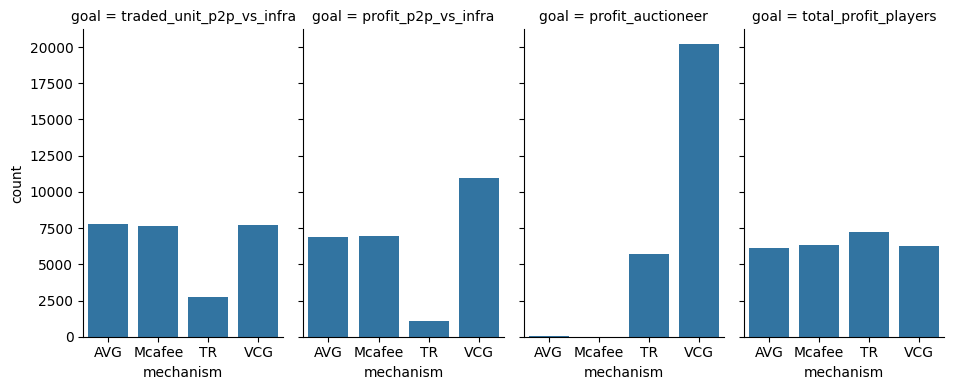

In [33]:
counters = [Counter(labels_goal1), Counter(labels_goal2), Counter(labels_goal3), Counter(labels_goal5)]
data = {
    'mechanism': ['AVG', 'Mcafee', 'TR', 'VCG'] * len(counters),
    'count': sum([[counter[i] for i in range(4)] for counter in counters],[]),
    'goal': [goal for goal in ['traded_unit_p2p_vs_infra', 'profit_p2p_vs_infra', 'profit_auctioneer', 'total_profit_players'] for _ in range(4)]
}
df_labels = pd.DataFrame(data)
print(data)
sns.catplot(
    data=df_labels, x="mechanism", y="count", col="goal",
    kind="bar", height=4, aspect=.6,
)

In [28]:

data = {
    "num_of_participants": [],
    "total_unit_buyers": [],
    "total_unit_sellers": [],
    "avg_unit_buyers": [],
    "avg_unit_sellers": [],
    "avg_unit_buyers_hour": [],
    "avg_unit_sellers_hour": [],
    "avg_prices_buyers": [],
    "avg_prices_sellers": [],
    "avg_prices_buyers_hour": [],
    "avg_prices_sellers_hour": [],
    # "avg_d_prices_buyers_hour": [],
    # "avg_d_prices_sellers_hour":[]
}


class Idea1(MechanismSelector):
    parallel_run = False


    # storing data classified by hour
    bms_by_hour = [[] for _ in range(24)]
    buyers_by_hour = [[] for _ in range(24)]
    sellers_by_hour = [[] for _ in range(24)]
    num_of_participants_by_hour = [[] for _ in range(24)]
    avg_unit_buyers_by_hour = [0 for _ in range(24)]
    avg_unit_sellers_by_hour = [0 for _ in range(24)]
    avg_prices_buyers_by_hour = [[] for _ in range(24)]
    avg_prices_sellers_by_hour = [[] for _ in range(24)]
    avg_price_buyers_by_hour = [0 for _ in range(24)]
    avg_price_sellers_by_hour = [0 for _ in range(24)]
    avg_prices_buyers = []
    avg_prices_sellers = []
    avg_d_prices_buyers = []
    avg_d_prices_sellers = []
    avg_d_price_buyers_by_hour = [0 for _ in range(24)]
    avg_d_price_sellers_by_hour = [0 for _ in range(24)]
    avg_score_participants = []
    num_of_transactions_by_hour = [[] for _ in range(24)]
    auctioneer_total_profit = 0

    def update_general(self):
        self.current_round = self.bm_list[-1]
        self.current_round_index = len(self.bm_list)
        self.current_round_hour = self.current_round_index % 24
        self.bms_by_hour[self.current_round_hour].append(self.current_round)
        self.buyers_by_hour[self.current_round_hour].append(
            [b for i, b in self.current_round.buyers.iterrows()]
        )
        self.sellers_by_hour[self.current_round_hour].append(
            [s for i, s in self.current_round.sellers.iterrows()]
        )

    def update_num_of_participants(self):
        self.num_of_participants_by_hour[self.current_round_hour].append(
            self.current_round.get_number_of_participants()
        )
        data["num_of_participants"].append(self.current_round.get_number_of_participants())

    def update_units(self):
        b = [b.unit for i, b in self.current_round.buyers.iterrows()]
        s = [b.unit for i, b in self.current_round.sellers.iterrows()]

        data["total_unit_buyers"].append(sum(b))
        data["total_unit_sellers"].append(sum(b))


        mean_b = calc_mean(b)
        mean_s = calc_mean(s)
        self.avg_unit_current_round_buyers = mean_b
        self.avg_unit_current_round_sellers = mean_s

        data["avg_unit_buyers"].append(mean_b)
        data["avg_unit_sellers"].append(mean_s)

        avg_b = (
            self.avg_unit_buyers_by_hour[self.current_round_hour]
            * (len(self.bms_by_hour[self.current_round_hour]) - 1)
            + self.avg_unit_current_round_buyers
        ) / len(self.bms_by_hour[self.current_round_hour])
        avg_s = (
            self.avg_unit_sellers_by_hour[self.current_round_hour]
            * (len(self.bms_by_hour[self.current_round_hour]) - 1)
            + self.avg_unit_current_round_sellers
        ) / len(self.bms_by_hour[self.current_round_hour])

        self.avg_unit_buyers_by_hour[self.current_round_hour] = avg_b
        self.avg_unit_sellers_by_hour[self.current_round_hour] = avg_s

        data["avg_unit_buyers_hour"].append(avg_b)
        data["avg_unit_sellers_hour"].append(avg_s)

    def update_price(self):
        self.avg_price_current_round_buyers = calc_mean(
            [b.price for i, b in self.current_round.buyers.iterrows()]
        )
        self.avg_prices_buyers.append(self.avg_price_current_round_buyers)
        self.avg_prices_buyers_by_hour[self.current_round_hour].append(
            self.avg_price_current_round_buyers
        )

        self.avg_price_current_round_sellers = calc_mean(
            [b.price for i, b in self.current_round.sellers.iterrows()]
        )
        self.avg_prices_sellers.append(self.avg_price_current_round_sellers)
        self.avg_prices_sellers_by_hour[self.current_round_hour].append(
            self.avg_price_current_round_sellers
        )
        data["avg_prices_buyers"].append(self.avg_price_current_round_buyers)
        data["avg_prices_sellers"].append(self.avg_price_current_round_sellers)

        avg_b = (
            self.avg_price_buyers_by_hour[self.current_round_hour]
            * (len(self.bms_by_hour[self.current_round_hour]) - 1)
            + self.avg_price_current_round_buyers
        ) / len(self.bms_by_hour[self.current_round_hour])
        self.avg_price_buyers_by_hour[self.current_round_hour] = avg_b

        avg_s = (
            self.avg_price_sellers_by_hour[self.current_round_hour]
            * (len(self.bms_by_hour[self.current_round_hour]) - 1)
            + self.avg_price_current_round_sellers
        ) / len(self.bms_by_hour[self.current_round_hour])
        self.avg_price_sellers_by_hour[self.current_round_hour] = avg_s 
        data["avg_prices_buyers_hour"].append(avg_b)
        data["avg_prices_sellers_hour"].append(avg_s)

    def update_d_price(self):
        if len(self.avg_d_prices_buyers) > 0:
            d = self.avg_price_current_round_buyers - self.avg_d_prices_buyers[-1]
            self.avg_d_prices_buyers.append(d)
            avg_b = (
                self.avg_d_price_buyers_by_hour[self.current_round_hour]
                * (len(self.bms_by_hour[self.current_round_hour]) - 2)
                + d
            ) / len(self.bms_by_hour[self.current_round_hour] - 1)
            self.avg_d_price_buyers_by_hour[self.current_round_hour] = avg_b
            # data["avg_d_prices_buyers_hour"].append(avg_b)

        if len(self.avg_d_prices_sellers) > 0:
            d = self.avg_price_current_round_sellers - self.avg_d_prices_sellers[-1]
            self.avg_d_prices_sellers.append(d)
            avg_s = (
                self.avg_d_price_sellers_by_hour[self.current_round_hour]
                * (len(self.bms_by_hour[self.current_round_hour]) - 2)
                + d
            ) / len(self.bms_by_hour[self.current_round_hour] - 1)
            self.avg_d_price_sellers_by_hour[self.current_round_hour] = avg_s
            # data["avg_d_prices_sellers_hour"].append(avg_s)

    def update_user_score(self):
        self.current_round_avg_score_of_participants = 0

        # buyers
        current_round_buyers_prices = [
            b.price for i, b in self.current_round.buyers.iterrows()
        ]
        for i, b in self.current_round.buyers.iterrows():
            user = User(b.user)
            distanceToMeanPrice = calc_zscore(current_round_buyers_prices, b.price)
            distanceToMeanPrice = (
                np.log(np.abs(distanceToMeanPrice))
                if distanceToMeanPrice != np.nan
                else 0
            )
            if b.is_peak:
                user.score += distanceToMeanPrice - 2
            else:
                user.score += distanceToMeanPrice - 1
            if len(user.transactions) > 0:
                last_transaction = user.transactions[-1]
                if last_transaction.mechanism_name == "Leftover_Clear":
                    user.score -= 1
                else:
                    user.score += 1
            self.current_round_avg_score_of_participants += user.score

        # sellers
        current_round_sellers_prices = [
            b.price for i, b in self.current_round.buyers.iterrows()
        ]
        for i, s in self.current_round.sellers.iterrows():
            user = User(s.user)
            distanceToMeanPrice = calc_zscore(current_round_sellers_prices, b.price)
            distanceToMeanPrice = (
                np.log(np.abs(distanceToMeanPrice))
                if distanceToMeanPrice != np.nan
                else 0
            )
            if s.is_peak:
                user.score += distanceToMeanPrice + 2
            else:
                user.score += distanceToMeanPrice + 1
            if len(user.transactions) > 0:
                last_transaction = user.transactions[-1]
                if last_transaction.mechanism_name == "Leftover_Clear":
                    user.score -= 1
                else:
                    user.score += 1
            self.current_round_avg_score_of_participants += user.score

        if len(self.current_round.buyers) + len(self.current_round.sellers) > 0:
            self.current_round_avg_score_of_participants = (
                self.current_round_avg_score_of_participants
                / (len(self.current_round.buyers) + len(self.current_round.sellers))
            )

    def update(self):
        self.update_general()
        self.update_num_of_participants()
        self.update_units()
        self.update_price()
        self.update_d_price()

    def select(self) -> Generator[Type[Mechanism], None, None]:
        weight = 0
        thresh = 3
        auctioneer_profit_thresh = 1000

        while True:
            self.update()

            # global scores for each mechnism TODO: should be automated since number of mechanisms in the future are not known
            avg_mechanism_score = 0
            vcg_mechanism_score = 0
            mcafee_mechanism_score = 0
            trm_mechanism_score = 0

            # avg prticipants
            weight = self.kwargs["avg_prticipants"]

            z_score = calc_zscore(
                self.num_of_participants_by_hour[self.current_round_hour][:-1],
                self.num_of_participants_by_hour[self.current_round_hour][-1],
            )

            if z_score != np.nan:
                if z_score > 0 and z_score > thresh:
                    avg_mechanism_score += weight
                elif z_score < 0 and z_score < -thresh:
                    vcg_mechanism_score += weight

            # avg units
            weight = self.kwargs["avg_units"]

            if (
                self.avg_unit_sellers_by_hour[self.current_round_hour] > 0
                and self.avg_unit_current_round_sellers > 0
            ):
                if (
                    self.avg_unit_buyers_by_hour[self.current_round_hour]
                    / self.avg_unit_sellers_by_hour[self.current_round_hour]
                ) < (
                    self.avg_unit_current_round_buyers
                    / self.avg_unit_current_round_sellers
                ):
                    trm_mechanism_score += weight
                else:
                    vcg_mechanism_score += weight

            # avg price
            weight = self.kwargs["avg_price"]

            z_score_buyers = calc_zscore(
                self.avg_prices_buyers[:-1],
                self.avg_prices_buyers[-1],
            )
            z_score_sellers = calc_zscore(
                self.avg_prices_sellers_by_hour[self.current_round_hour][:-1],
                self.avg_prices_sellers_by_hour[self.current_round_hour][-1],
            )

            if z_score_buyers != np.nan:
                if z_score_buyers > 0 and np.abs(z_score_buyers) > thresh:
                    trm_mechanism_score += weight
                else:
                    mcafee_mechanism_score += weight/2
            if z_score_sellers != np.nan:
                if z_score_sellers > 0 and np.abs(z_score_sellers) > thresh:
                    trm_mechanism_score += weight
                else:
                    mcafee_mechanism_score += weight/2

            if (
                self.avg_price_current_round_buyers
                > self.avg_price_current_round_sellers
            ):
                vcg_mechanism_score += weight
            else:
                mcafee_mechanism_score += weight

            # users score
            # weight = self.kwargs['avg_users']

            # mean = calc_mean(self.avg_score_participants)
            # self.avg_score_participants.append(
            #     self.current_round_avg_score_of_participants
            # )
            # if mean < self.current_round_avg_score_of_participants:
            #     vcg_mechanism_score += weight

            # # peak/nonpeak
            # weight = self.kwargs["peak_or_nonpeak"]
            # is_peak = self.current_round.get_df()["is_peak"][0]
            # if is_peak:
            #     trm_mechanism_score -= weight
            #     mcafee_mechanism_score -= weight

            # number of matched orders
            weight = self.kwargs["number_of_matched_orders"]

            if len(self.tm_list) > 1:
                last_tm =self.tm_list[-2]
                last_round_num_of_transactions = len(last_tm.trans)
                self.num_of_transactions_by_hour[self.current_round_hour].append(
                    last_round_num_of_transactions
                )
                z_score = calc_zscore(
                    self.num_of_transactions_by_hour[self.current_round_hour][:-1],
                    last_round_num_of_transactions,
                )
                if z_score != np.nan:
                    if z_score > 0 and z_score > thresh:
                        avg_mechanism_score += weight
                    elif z_score < 0 and z_score < -thresh:
                        vcg_mechanism_score += weight

            # auctioneer
            if len(self.tm_list) > 1:
                last_tm =self.tm_list[-2]
                self.auctioneer_total_profit += last_tm.get_auctioneer_profit()

            # select best mechanism regarding to it's score
            # just a simple max function needed and then yield the corresponding mechanism
            max_score = max(
                avg_mechanism_score,
                vcg_mechanism_score,
                trm_mechanism_score,
                mcafee_mechanism_score,
            )
            # print(
            #     avg_mechanism_score,
            #     trm_mechanism_score,
            #     vcg_mechanism_score,
            #     mcafee_mechanism_score,
            # )
            if max_score == 0:
                yield (Average_Mechanism_Multi, Leftover_Clear)
                # print("no-one")
            elif max_score == avg_mechanism_score:
                yield (Average_Mechanism_Multi, Leftover_Clear)
                # print("average")
            elif (
                max_score == vcg_mechanism_score
                and self.current_round.run((VCG_Mechanism_Multi,))[1].get_auctioneer_profit()
                + self.auctioneer_total_profit
                > auctioneer_profit_thresh
            ):
                yield (VCG_Mechanism_Multi, Leftover_Clear)
                # print("VCG")
            elif max_score == mcafee_mechanism_score:
                yield (Macafee_Mechanism_Multi, Leftover_Clear)
                # print("mcafee")
            elif max_score == trm_mechanism_score:
                yield (TradeReduction_Mechanism_Multi, Leftover_Clear)
                # print("TRM")
            else:
                yield (Macafee_Mechanism_Multi, Leftover_Clear)
                # print("default")


# weights = {
#     "avg_prticipants": 1,
#     "avg_units": 1,
#     "avg_price": 1,
#     "peak_or_nonpeak": 1,
#     "number_of_matched_orders": 1,
# }
weights = {
    "avg_prticipants": 0.8832616325,
    "avg_units": -1.2976194675,
    "avg_price": -1.2169124025,
    "peak_or_nonpeak": 1.021736445,
    "number_of_matched_orders": -0.49396082,
}

m = Market(Idea1, bid_selector_1h, df, **weights)
# cProfile.run('m.run(p_feat, p_G)',filename="run.profile",sort=1)
m.run(p_feat, p_G)
print("------ bm stats:")
print(m.get_BMs_stats())

print("------ tm stats:")
print(m.get_TMs_stats())

------ bm stats:
       breakeven
0              0
1              0
2              0
3              0
4              0
...          ...
25916          4
25917          3
25918          3
25919          8
25920          0

[25921 rows x 1 columns]
------ tm stats:
       players_total_trade_profit  players_total_trade_unit  \
0                   526854.480000              15793.000000   
1                   484654.080000              14528.000000   
2                   665365.200000              19945.000000   
3                   827161.200000              24795.000000   
4                   662929.920000              19872.000000   
...                           ...                       ...   
25915               574129.632367              17233.261194   
25916               544043.562248              16336.487892   
25917               619550.160805              18576.908420   
25918               870577.779082              26115.147290   
25919               606928.402701          

# ----------------------------------------

In [ ]:
selected_mechanisms = [tm.mechanism_name for tm in m.tm_list]

is_correct_list1 = [best == selected for selected, best in zip(selected_mechanisms, bests["best_num_of_transactions"])]
is_correct_list2 = [best == selected for selected, best in zip(selected_mechanisms, bests["best_profit_auctioneer"])]
is_correct_list3 = [best == selected for selected, best in zip(selected_mechanisms, bests["best_profit_players"])]
is_correct_list4 = [best == selected for selected, best in zip(selected_mechanisms, bests["best_percentage_traded_unit_p2p"])]
print("best_num_of_transactions: ", sum(is_correct_list1)/len(is_correct_list1)*100.0)
print("best_profit_auctioneer: ", sum(is_correct_list2)/len(is_correct_list2)*100.0)
print("best_profit_players: ", sum(is_correct_list3)/len(is_correct_list3)*100.0)
print("best_percentage_traded_unit_p2p: ", sum(is_correct_list4)/len(is_correct_list4)*100.0)

print("percentage_of_p2p_transactions")
print(m.get_percentage_of_p2p_transactions())
print("profit auctioneer")
print(m.get_auctioneer_profit())
print("profit_players")
print(m.get_players_profit_p2p_vs_infra(p_G, p_feat))
print("percentage_traded_unit_p2p")
print(m.get_total_traded_unit_p2p() / market_tr.get_players_total_trade_unit())


In [ ]:
mech2weight = {
    Average_Mechanism_Multi: mech_percentage["Average_Mechanism_Multi"],
    TradeReduction_Mechanism_Multi: mech_percentage["TradeReduction_Mechanism_Multi"],
    Macafee_Mechanism_Multi: mech_percentage["Macafee_Mechanism_Multi"],
    VCG_Mechanism_Multi: mech_percentage["VCG_Mechanism_Multi"],
}
random_market = Market(MechanismSelectorRandom, bid_selector_1h, df, mech2weight)

random_market.run(p_feat, p_G)


In [ ]:
selected_mechanisms = [tm.mechanism_name for tm in random_market.tm_list]

is_correct_list = [best == selected for selected, best in zip(selected_mechanisms, bests["best_num_of_transactions"])]
print("Eval: ", sum(is_correct_list)/len(is_correct_list)*100.0)


print("percentage_of_p2p_transactions")
print(random_market.get_percentage_of_p2p_transactions())
print("profit auctioneer")
print(random_market.get_auctioneer_profit())
print("profit_players")
print(random_market.get_players_profit_p2p_vs_infra(p_G, p_feat))
print("percentage_traded_unit_p2p")
print(random_market.get_total_traded_unit_p2p() / market_tr.get_players_total_trade_unit())

# genetic

In [ ]:
import pygad


def fitness_func(ga_instance, solution, solution_idx):
    weights = {
        "avg_prticipants": solution[0],
        "avg_units": solution[1],
        "avg_price": solution[2],
        "peak_or_nonpeak": solution[3],
        "number_of_matched_orders": solution[4],
    }
    m = Market(Idea1, bid_selector_1h, df, **weights)
    m.run(p_feat, p_G)

    selected_mechanisms = [tm.mechanism_name for tm in m.tm_list]
    is_correct_list = [
        best == selected for selected, best in zip(selected_mechanisms, bests["best_profit_players"])
    ]
    return sum(is_correct_list) / len(is_correct_list)


# pygad parameters
fitness_function = fitness_func

num_generations = 20
num_parents_mating = 2

sol_per_pop = 8
num_genes = len(weights)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

def on_generation(ga_instance):
    print("on_generation()")

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    parent_selection_type=parent_selection_type,
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    parallel_processing=["process", 8],
    on_generation=on_generation
)
ga_instance.run()


In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

In [ ]:
# best_best_num_of_transactions [ 0.94348053 -2.2396526  -1.54749413 -0.16060439 -0.34917297] 0.5201388888888889
# best_profit_auctioneer [-0.91109747  1.06519154 -1.00293293  1.65499225 -0.59739237] 0.6729166666666667
# best_percentage_traded_unit_p2p [ 2.54069302 -0.70088259 -0.105441    2.78022935 -0.33039472] 0.5666666666666667
# best_profit_players [ 0.95997045 -3.31513422 -2.21178155 -0.18767143 -0.69888322] 0.5895833333333333

# 0.8832616325	-1.2976194675	-1.2169124025	1.021736445	-0.49396082


In [ ]:
p2p_tms = tms[tms['mechanism'] != "Leftover_Clear"]
infra_tms = tms[tms['mechanism'] == "Leftover_Clear"]
p2p_tms.reset_index(inplace=True, drop=True)
infra_tms.reset_index(inplace=True, drop=True)
p2p_tms_filter = p2p_tms.iloc[450:550]
infra_tms_filter = infra_tms.iloc[450:550]
p2p_tms_filter

In [ ]:
# p2p
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=p2p_tms, x=p2p_tms.index, y='number_of_transactions', marker='o', label='p2p transactions')
sns.lineplot(data=infra_tms, x=infra_tms.index, y='number_of_transactions', marker='o', label='infra transactions')
plt.title('Number of transactions using P2P vs Infra')
plt.xlabel('Round')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [ ]:
# p2p
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=p2p_tms_filter, x=p2p_tms_filter.index, y='players_total_trade_profit', marker='o', label='users total profit in p2p')
sns.lineplot(data=infra_tms_filter, x=infra_tms_filter.index, y='players_total_trade_profit', marker='o', label='users total profit in infra')
sns.lineplot(data=p2p_tms_filter, x=p2p_tms_filter.index, y='auctioneer_profit', marker='o', label='auctioneer total profit')
plt.title('Profits over rounds using P2P')
plt.xlabel('Round')
plt.ylabel('Profit')
plt.yscale('log')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

# unit
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=p2p_tms_filter, x=p2p_tms_filter.index, y='players_total_trade_unit', marker='o', label='users total units traded in p2p')
sns.lineplot(data=infra_tms_filter, x=infra_tms_filter.index, y='players_total_trade_unit', marker='o', label='users total units traded in infra')
plt.title('Units traded over rounds')
plt.xlabel('Round')
plt.ylabel('Unit')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


In [ ]:
# infra
from matplotlib.ticker import FuncFormatter
total_profit_users_p2p = np.sum(p2p_tms['players_total_trade_profit'])
total_profit_users_infra = np.sum(infra_tms['players_total_trade_profit'])
total_profit_auctioneer = np.sum(p2p_tms['auctioneer_profit'])
total_profit= total_profit_users_p2p + total_profit_users_infra+ total_profit_auctioneer

profits_map = {
    "categories": ['total profit users in p2p', 'total profit users in infra', 'total profit auctioneer'],
    "values": [total_profit_users_p2p/total_profit*100.0, total_profit_users_infra/total_profit*100.0, total_profit_auctioneer/total_profit*100.0],
}
profits_df = pd.DataFrame(profits_map)
plt.figure(figsize=(10, 6))
plt.title('Total profit comparison')
sns.barplot(x='categories', y='values', data=profits_df)

# Scale the y-axis to show percentages
plt.ylim(0, 100)  # Set the y-axis limits
plt.yticks(ticks=range(0, 101, 10))  # Set y-ticks from 0 to 100 with a step of 10

# Define a function to format the y-axis ticks as percentages
def to_percent(y, position):
    return f'{y}%'

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# plt.yscale('log')
plt.ylabel('profit')
profits_df


In [ ]:
users = [u for i,u in User._instances.items()]
users_df = pd.json_normalize([u.as_dict() for u in users])
users_columns = ['id', 'score', 'total_trade_p2p', 'total_trade_infra', 'total_trade']
u_df = users_df[users_columns]

# Merging the two DataFrames on the user ID
df2 = u_df.merge(df, left_on='id', right_on='user', how='left')
df2 = df2[users_columns + ['type']]
df2.dropna(inplace=True)
df2['type'] = df2['type'].astype(int)

# groupby type
df2 = df2.groupby('type').agg({'total_trade_p2p': 'sum', 'total_trade_infra': 'sum'}).reset_index()
df2 = df2.melt(id_vars=['type'], value_vars=['total_trade_p2p', 'total_trade_infra'],
                    var_name='trade_type', value_name='total_trade_value')
plt.figure(figsize=(6, 4))
sns.barplot(data=df2, x='type', y='total_trade_value', hue='trade_type')
plt.xlabel('User Type')
plt.ylabel('Total Trade Value')
plt.title('Comparison of Total Trade (P2P vs Infra) by User Type')
plt.legend(title='Trade Type')
plt.xticks(rotation=0)  # Rotate x labels if needed
plt.tight_layout()

plt.show()

In [ ]:
top_users_largest = {}
top_users_smallest = {}
for feature in users_columns[1:]:
    top_users_largest[feature] = users_df.nlargest(5, feature)  # Get top 5 users for each feature
for feature in users_columns[1:]:
    top_users_smallest[feature] = users_df.nsmallest(5, feature)  # Get bottom 5 users for each feature


# Display the top users for each feature
for feature, users in top_users_largest.items():
    print(f"Top users for {feature}:")
    print(users[['id', feature]])
    print("\n")

# Display the bottom users for each feature
for feature, users in top_users_smallest.items():
    print(f"Bottom users for {feature}:")
    print(users[['id', feature]])
    print("\n")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=tms, x=tms.index, y='average_score_of_users', marker='o', label='average score of users')
plt.title('scores')
plt.xlabel('Round')
plt.ylabel('average score')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [ ]:
# all the transactions
transactions_raw = pd.concat([tm.get_df() for tm in m.tm_list])
transactions_raw

In [ ]:
l = []
for i,t in transactions_raw.iterrows():
    b_type = buyers_df.loc[buyers_df['user'] == t['buyer.id'], 'type'].unique()
    s_type = sellers_df.loc[sellers_df['user'] == t['seller.id'], 'type'].unique()
    b = {
        "time": t['time'],
        "user": t['buyer.id'],
        "type": b_type[0] if len(b_type) == 1 else 0,
        "is_seller": False,
        "matched_price": t['mechanism.buy_price'],
        "matched_unit": t['mechanism.unit'],
        "bid_price": t['buyer.price'],
        "bid_unit": t['buyer.unit'],
        "remaining_unit": t['buyer.remaining_unit']
    }
    s = {
        "time": t['time'],
        "user": t['seller.id'],
        "type": s_type[0] if len(s_type) == 1 else 0,
        "is_seller": True,
        "matched_price": t['mechanism.sell_price'],
        "matched_unit": t['mechanism.unit'],
        "bid_price": t['seller.price'],
        "bid_unit": t['seller.unit'],
        "remaining_unit": t['seller.remaining_unit']
    }
    l.append(s)
    l.append(b)
transactions = pd.DataFrame(l)
transactions

In [ ]:
print("percentage of p2p transactions:")
(1-len(transactions[transactions["matched_price"].isin([p_feat, p_G])])/len(transactions))*100
# transactions

In [ ]:
print("percentage of p2p units:")
total_unit_infra=sum(transactions_raw.loc[transactions_raw['mechanism.name'] == 'Leftover_Clear','mechanism.unit'])
total_unit_p2p=sum(transactions_raw.loc[transactions_raw['mechanism.name'] != 'Leftover_Clear','mechanism.unit'])
total_unit_p2p/(total_unit_p2p+total_unit_infra)*100

In [ ]:
ks = [bm.get_breakeven_index() for bm in m.bm_list]

In [ ]:
df_ks = pd.DataFrame(ks, columns=['breakeven'])
plt.figure(figsize=(15, 6))
plt.title('Number of matches in rounds')
sns.countplot(x='breakeven', data=df_ks)
# TODO: how to retrieve rounds that have breakeven == 0? i guess we need a dataframe or something for this

In [ ]:
ps = [bm.get_number_of_participants() for bm in m.bm_list]
df_ps = pd.DataFrame(ps, columns=['participants'])
# plt.figure(figsize=(6, 6))
plt.title('Number of participants in rounds')
sns.countplot(x='participants', data=df_ps)

In [ ]:
num_of_sellers_over_time = [len(bm.sellers) for bm in m.bm_list]
df_num_sellers = pd.DataFrame(num_of_sellers_over_time, columns=['sellers'])
plt.figure(figsize=(30, 6))
plt.title('Number of sellers in rounds')
sns.countplot(x='sellers', data=df_num_sellers)

In [ ]:
sum(ps)

In [ ]:
tms.to_csv('mechanisms.csv', index=False)
users_df[users_columns].to_csv('users.csv', index=False)
transactions.to_csv('transactions.csv', index=False)

In [ ]:
print("total profit of users at all")
print(sum(tms['players_total_trade_profit']))
print()

print("total traded unit of users at all")
print(sum(tms['players_total_trade_unit']))
print()

print("total auctioneer profit")
print(sum(tms['auctioneer_profit']))
print()

In [ ]:
total_req_scenario1 = np.sum(df['load'])
total_buy_from_infra_scenario1 = total_req_scenario1 * p_G

need = df['load']-df['generate']
need = need[need > 0].reset_index(drop=True)
total_req_scenario2 = np.sum(need)
total_buy_from_infra_scenario2 = total_req_scenario2 * p_G

total_req_scenario3 = np.sum(transactions.loc[(transactions['user'] == -1) & (transactions['is_seller'] == True), 'matched_unit'])
# total_req_scenario3 = 29570692.5
total_buy_from_infra_scenario2 = total_req_scenario3 * p_G

total_req = total_req_scenario1

map = {
    "categories": ['no generate and no p2p', 'generate and no p2p', 'generate and p2p'],
    "values": [total_req_scenario1/total_req*100.0, total_req_scenario2/total_req*120.0, total_req_scenario3/total_req*60.0],
}
l_df = pd.DataFrame(map)
plt.figure(figsize=(10, 6))
plt.title('Total units buyed from infra')
sns.barplot(x='categories', y='values', data=l_df)

# # Scale the y-axis to show percentages
plt.ylim(0, 100)  # Set the y-axis limits
plt.yticks(ticks=range(0, 101, 10))  # Set y-ticks from 0 to 100 with a step of 10

# # Define a function to format the y-axis ticks as percentages
def to_percent(y, position):
    return f'{y}%'

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# plt.yscale('log')
plt.ylabel('unit')
plt.xlabel('')
l_df